In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

## 1. Recursive Filter Method

## 1.1 Convolution Integral Method

$\ddot{x}_n = b_0 \cdot \ddot{y}_n + b_1 \cdot \ddot{y}_{n-1} + b_2 \cdot \ddot{y}_{n-2} - a_1 \cdot \ddot{x}_{n-1} - a_2 \cdot \ddot{x}_{n-2}$

$b_0=2\zeta\omega_n\Delta t$

$b_1=\omega_n\Delta t exp[-\zeta\omega_n\Delta t]\left\{ \left[ \frac{\omega_n}{\omega_d}(1-2\zeta^2) \right]sin[\omega_d \Delta t]-2\zeta cos[\omega_d \Delta t] \right\}$

$b_2 = 0$

$a_1 = -2exp[-\zeta\omega_n\Delta t]cos[\omega_d\Delta t]$

$a_2 = exp[-2\zeta\omega_n\Delta t]$

In [2]:
# th_in : acceleration time history at base
# th_out : acceleration time history at mass
def SDOF_conv(th_in,dt,fn,zeta): # Kelly-Richman

    wn = 2*np.pi*fn;
    wd = wn*np.sqrt(1-zeta**2);
    
    a, b = np.zeros(3), np.zeros(3);

    b[0] = 2*zeta*wn*dt;
    b[1] = wn*dt*np.exp(-zeta*wn*dt)*((wn/wd)*(1-2*zeta**2)*np.sin(wd*dt)-2*zeta*np.cos(wd*dt));
    b[2] = 0;

    a[0] = 1
    a[1] = -2*np.exp(-zeta*wn*dt)*np.cos(wd*dt);
    a[2] = np.exp(-2*zeta*wn*dt);

    th_out=lfilter(b, a, th_in, axis=-1, zi=None);
    
    return th_out;

## 1.2 Ramp Invariant Method (ISO 18431-4)

Shock Response Spectra 계산 Coefficient

$\ddot{x}_n = b_0 \cdot \ddot{y}_n + b_1 \cdot \ddot{y}_{n-1} + b_2 \cdot \ddot{y}_{n-2} - a_1 \cdot \ddot{x}_{n-1} - a_2 \cdot \ddot{x}_{n-2}$

$b_0 = 1- exp(-A)\cdot sin(B)/B$

$b_1 = 2exp(-A)\cdot {sin(B)/B - cos(B)}$

$b_2 = exp(-2A)-exp(-A)\cdot sin(B)/B$

$a_1 = -2exp(-A)\cdot cos(B)$

$a_2 = exp(-2A)$

$A = \frac{\omega_n \cdot T}{2Q}$

$B = \omega_n \cdot T \cdot \sqrt{1-\frac{1}{4Q^2}}$

In [3]:
# th_in : acceleration time history at base
# th_out : acceleration time history at mass
def SDOF_ISO(th_in,dt,fn,zeta): 

    wn = 2*np.pi*fn;
    wd = wn*np.sqrt(1-zeta**2);
    A=wn*dt*zeta;
    B=wd*dt;
    
    a, b = np.zeros(3), np.zeros(3);

    b[0] = 1 - np.exp(-A)*np.sin(B)/B;
    b[1] = 2*np.exp(-A)*(np.sin(B)/B - np.cos(B));
    b[2] = np.exp(-2*A) - np.exp(-A) * np.sin(B)/B;

    a[0] = 1;
    a[1] = -2*np.exp(-A)*np.cos(B);
    a[2] = np.exp(-2*A);

    th_out=lfilter(b, a, th_in, axis=-1, zi=None);
    
    return th_out;

In [4]:
# th_in : acceleration time history at base
# th_out : acceleration time history at mass
def SDOF_ramp_invariant(th_in,dt,fn,zeta): # Smallwood
    
    wn = 2*np.pi*fn;
    wd = wn*np.sqrt(1-zeta**2);
    E = np.exp(-zeta*wn*dt);
    K = dt*wd;
    C = E*np.cos(K);
    S = E*np.sin(K);
    Sp = S/K;
    
    a, b = np.zeros(3), np.zeros(3);

    b[0] = 1 - Sp;
    b[1] = 2*(Sp-C);
    b[2] = E**2 - Sp;

    a[0] = 1;
    a[1] = -2*C;
    a[2] = E**2;

    th_out=lfilter(b, a, th_in, axis=-1, zi=None);
    
    return th_out;        

## 2. Exact Solution Method

## 2.1 Duhamel's Integral Method

$$x_i=\frac{e^{-\zeta \omega t_i}}{m\omega_d}[A_D(t_i)sin\omega_d t_i - B_D(t_i) cos\omega_d t_i]$$

$$\dot{x}_i=\frac{e^{-\zeta \omega t_i}}{m \omega_d}\left\{ \left[ \omega_d B_D(t_i) - \zeta \omega A_D(t_i) \right]sin\omega_d t_i + \left[ \omega_d A_D(t_i) + \zeta\omega B_D(t_i) \right]cos\omega_d t_i \right\}$$

$$\ddot{x}_i=\frac{1}{m}(P_i-c\dot{x}_i-kx_i)$$

where,

$$A_D(t_i)=A_D(t_{i-1})+\left[P(t_{i-1})-t_{i-1}\frac{\Delta P_i}{\Delta t}\right]I_1+\frac{\Delta P_i}{\Delta t}I_4$$

$$B_D(t_i)=B_D(t_{i-1})+\left[P(t_{i-1})-t_{i-1}\frac{\Delta P_i}{\Delta t}\right]I_2 + \frac{\Delta P_i}{\Delta t}I_3$$

$$I_1=\int_{t_{i-1}}^{t_i} e^{\zeta \omega \tau}cos\omega_d\tau d\tau=
\frac{e^{\zeta \omega \tau}}{(\zeta \omega)^2+\omega_d^2}
(\zeta\omega cos\omega_d\tau+\omega_d sin\omega_d\tau)|_{t_{i-1}}^{t_i}
$$

$$I_2
=\int_{t_{i-1}}^{t_i} e^{\zeta \omega \tau}sin\omega_d\tau d\tau=
\frac{e^{\zeta \omega \tau}}{(\zeta \omega)^2+\omega_d^2}
(\zeta\omega sin\omega_d\tau-\omega_d cos\omega_d\tau)|_{t_{i-1}}^{t_i}
$$

$$I_3=
\int_{t_{i-1}}^{t_i}\tau e^{\zeta \omega\tau}sin\omega_d\tau d\tau
=\left[\tau-\frac{\zeta\omega}{(\zeta\omega)^2+\omega_d^2}\right] I_2^{'}
+\frac{\omega_d}{(\zeta\omega_d)^2+\omega_d^2}I_1^{'}|_{t_{i-1}}^{t_i}
$$

$$I_4=
\int_{t_{i-1}}^{t_i}\tau e^{\zeta \omega\tau}cos\omega_d\tau d\tau
=\left[\tau-\frac{\zeta\omega}{(\zeta\omega)^2+\omega_d^2}\right] I_1^{'}
+\frac{\omega_d}{(\zeta\omega_d)^2+\omega_d^2}I_2^{'}|_{t_{i-1}}^{t_i}
$$

$I_1^{'}$, $I_2^{'}$는 $I_1$, $I_2$ 적분 식에서 한계 값을 적용하지 않은 것을 의미

In [5]:
# th_in : acceleration time history at base
# th_out : acceleration time history at mass
def SDOF_duhamel(th_in,dt,fn,zeta):
    def Ad(Ad0,P0,t,dt,dP,I1,I4):
        return Ad0+(P0-(t-dt)*(dP/dt))*I1+(dP/dt)*I4;
    def Bd(Bd0,P0,t,dt,dP,I2,I3):
        return Bd0+(P0-(t-dt)*(dP/dt))*I2+(dP/dt)*I3;
    def I1p(zeta,wn,t):
        wd = wn*np.sqrt(1-zeta**2);
        return (np.exp(zeta*wn*t)/((zeta*wn)**2+wd**2))*(zeta*wn*np.cos(wd*t)+wd*np.sin(wd*t));
    def I2p(zeta,wn,t):
        wd = wn*np.sqrt(1-zeta**2);
        return (np.exp(zeta*wn*t)/((zeta*wn)**2+wd**2))*(zeta*wn*np.sin(wd*t)-wd*np.cos(wd*t));
    def I3p(zeta,wn,t):
        wd = wn*np.sqrt(1-zeta**2);
        return (t-((zeta*wn)/((zeta*wn)**2+wd**2)))*I2p(zeta,wn,t)+(wd/((zeta*wd)**2+wd**2))*I1p(zeta,wn,t);
    def I4p(zeta,wn,t):
        wd = wn*np.sqrt(1-zeta**2);
        return (t-((zeta*wn)/((zeta*wn)**2+wd**2)))*I1p(zeta,wn,t)+(wd/((zeta*wd)**2+wd**2))*I2p(zeta,wn,t);    
    u,v,ac = np.zeros(len(th_in)),np.zeros(len(th_in)),np.zeros(len(th_in));
    ru,rv,rac = np.zeros(len(th_in)),np.zeros(len(th_in)),np.zeros(len(th_in));
    N = len(th_in);
    t = np.arange(N)*dt; wn = 2*np.pi*fn; wd = wn*np.sqrt(1-zeta**2);
    m = 1; c = 2*zeta*wn; k = wn**2;   
    P = -th_in;
    Ad0 = np.zeros(len(th_in)); Bd0 = np.zeros(len(th_in));
    for n in range(len(th_in)-1):
        I1 = I1p(zeta,wn,t[n+1])-I1p(zeta,wn,t[n]); 
        I2 = I2p(zeta,wn,t[n+1])-I2p(zeta,wn,t[n]);
        I3 = I3p(zeta,wn,t[n+1])-I3p(zeta,wn,t[n]); 
        I4 = I4p(zeta,wn,t[n+1])-I4p(zeta,wn,t[n]);
        Ad0[n+1] = Ad(Ad0[n],P[n],t[n+1],dt,P[n+1]-P[n],I1,I4); Bd0[n+1] = Bd(Bd0[n],P[n],t[n+1],dt,P[n+1]-P[n],I2,I3);    
        ru[n+1] = (np.exp(-zeta*wn*t[n+1])/(m*wd))*(Ad0[n+1]*np.sin(wd*t[n+1])-Bd0[n+1]*np.cos(wd*t[n+1]));
        rv[n+1] = (np.exp(-zeta*wn*t[n+1])/(m*wd))*((wd*Bd0[n+1]-zeta*wn*Ad0[n+1])*np.sin(wd*t[n+1])+(wd*Ad0[n+1]+zeta*wn*Bd0[n+1])*np.cos(wd*t[n+1]));
        rac[n+1] = (1/m)*(P[n+1]-c*rv[n+1]-k*ru[n+1]);
    th_out= rac + th_in;
    return th_out;

## 2.2 Piecewise Linear Method (Piecewise Exact Method)

$$X_{i+1}=AX_i + B \ddot{X}_{ground\;i}$$

$$X_i=\begin{Bmatrix}
x_i \\
\dot{x}_i
\end{Bmatrix}
\;\;
\ddot{X}_{ground\;i}=
-\frac{1}{m}
\begin{Bmatrix}
P_i \\
P_{i+1}
\end{Bmatrix}
\tag{79}
$$

$$A=\begin{bmatrix}
a_{11} & a_{12} \\
a_{21} & a_{22} 
\end{bmatrix}
\;\;
B=\begin{bmatrix}
b_{11} & b_{12} \\
b_{21} & b_{22} 
\end{bmatrix}
\tag{80}$$

$$a_{11}=e^{-\zeta \omega \Delta t} \left(\frac{\omega \zeta}{\omega_d}sin\omega_d \Delta t + cos \omega_d \Delta t\right)$$

$$a_{12}=\frac{e^{-\zeta \omega \Delta t}}{\omega_d}sin\omega_d \Delta t$$

$$a_{21}=-\frac{\omega^2 e^{-\zeta \omega \Delta t}}{\omega_d} sin \omega_d \Delta t$$

$$a_{22}=e^{-\zeta \omega \Delta t}\left(cos\omega_d \Delta t - \frac{\omega \zeta}{\omega_d}sin\omega_d \Delta t\right)\tag{81}$$

$$b_{11}=e^{-\zeta\omega\Delta t}\left[ \left( \frac{2\zeta^2-1}{\omega^2 \Delta t}+\frac{\zeta}{\omega} \right)\frac{sin\omega_d \Delta t}{\omega_d} + \left( \frac{2\zeta}{\omega^3 \Delta t}+\frac{1}{\omega^3} \right)cos\omega_d\Delta t \right] - \frac{2\zeta}{\omega^3 \Delta t}$$

$$b_{12}=-e^{-\zeta\omega\Delta t}\left[ \left( \frac{2\zeta^2-1}{\omega^2 \Delta t}\right)\frac{sin\omega_d \Delta t}{\omega_d} +  \frac{2\zeta}{\omega^3 \Delta t} cos\omega_d\Delta t \right] - \frac{1}{\omega^2}  + \frac{2\zeta}{\omega^3 \Delta t}$$

$$b_{21}=e^{-\zeta \omega \Delta t}\left[ \left( \frac{2\zeta^2-1}{\omega^2\Delta t}+\frac{\zeta}{\omega} \right)\left( cos\omega_d\Delta t - \frac{\omega\zeta}{\omega_d}sin\omega_d \Delta t \right) - \left( \frac{2\zeta}{\omega^3\Delta t}+\frac{1}{\omega^3} \right)(\omega_d sin\omega_d\Delta t + \zeta\omega cos \omega_d \Delta t) \right]+\frac{1}{\omega^2 \Delta t}$$

$$b_{22}=-e^{\zeta \omega \Delta t}\left[ \frac{2\zeta^2-1}{\omega^2\Delta t}\left(cos\omega_d\Delta t - \frac{\omega\zeta}{\omega_d}sin\omega_d\Delta t\right) - \frac{2\zeta}{\omega^3\Delta t}(\omega_d sin\omega_d \Delta t + \zeta \omega cos \omega_d \Delta t) \right] - \frac{1}{\omega^2 \Delta t}\tag{82}$$

In [11]:
# th_in : acceleration time history at base
# th_out : acceleration time history at mass
def SDOF_pl(th_in,dt,fn,zeta): #piecewise linear method
    wn = 2*np.pi*fn; wd = wn*np.sqrt(1-zeta**2);
    m = 1; c = 2*zeta*wn; k = wn**2;   
    a = np.zeros([2,2]);
    a[0,0]=np.exp(-zeta*wn*dt)*(((wn*zeta)/wd)*np.sin(wd*dt)+np.cos(wd*dt));
    a[0,1]=(np.exp(-zeta*wn*dt)/wd)*np.sin(wd*dt);
    a[1,0]=-(wn**2*np.exp(-zeta*wn*dt)/wd)*np.sin(wd*dt);
    a[1,1]=np.exp(-zeta*wn*dt)*(np.cos(wd*dt)-(wn*zeta/wd)*np.sin(wd*dt));
    b = np.zeros([2,2]);
    b[0,0]=np.exp(-zeta*wn*dt)*(((2*zeta**2-1)/(wn**2*dt)+(zeta/wn))*(np.sin(wd*dt)/wd)+((2*zeta/(wn**3*dt))+(1/(wn**3)))*np.cos(wd*dt))-(2*zeta/(wn**3*dt));
    b[0,1]=-np.exp(-zeta*wn*dt)*(((2*zeta**2-1)/(wn**2*dt))*(np.sin(wd*dt)/wd)+(2*zeta/(wn**3*dt))*np.cos(wd*dt))-(1/wn**2)+(2*zeta/(wn**3*dt));
    b[1,0]=np.exp(-zeta*wn*dt)*((((2*zeta**2-1)/(wn**2*dt))+zeta/wn)*(np.cos(wd*dt)-(wn*zeta/wd)*np.sin(wd*dt))-((2*zeta/(wn**3*dt))+(1/(wn**3)))*(wd*np.sin(wd*dt)+zeta*wn*np.cos(wd*dt)))+(1/(wn**2*dt));
    b[1,1]=-np.exp(zeta*wn*dt)*(((2*zeta**2-1)/(wn**2*dt))*(np.cos(wd*dt)-(wn*zeta/wd*np.sin(wd*dt)))-(2*zeta/(wn**3*dt))*(wd*np.sin(wd*dt)+zeta*wn*np.cos(wd*dt)))-(1/(wn**2*dt));
    ru,rv,rac = np.zeros(len(th_in)),np.zeros(len(th_in)),np.zeros(len(th_in));
    X,Xg = np.zeros([2,len(th_in)]),np.zeros([2,len(th_in)-1]);
    for i in range(len(th_in)-1):
        Xg[0,i] = th_in[i]; Xg[1,i] = th_in[i+1];
    for n in range(len(th_in)-1):
        X[:,n+1] = a@X[:,n] + b@Xg[:,n];
        rac[n+1] = -th_in[n+1]-c*X[1,n+1]-k*X[0,n+1];
    th_out= rac + th_in;
    return th_out

## Newmark $\beta$ Method

In [7]:
# th_in : acceleration time history at base
# th_out : acceleration time history at mass
def SDOF_newmark(th_in,dt,fn,zeta):
    def newmark_parameter(dt):
        r = 0.005; alpha = (1/4)*((1+r)**2); delta = 0.5 + r;
        a = np.zeros(8);
        a[0] = 1/(alpha*dt*dt); a[1] = delta/(alpha*dt); a[2] = 1/(alpha*dt); a[3] = 1/(2*alpha)-1;
        a[4] = delta/alpha - 1; a[5] = (dt/2)*((delta/alpha)-2); a[6] = dt*(1-delta); a[7] = delta*dt;
        return a;
    def DERIV(X,Y):
        N = len(Y); YY = np.zeros(N);
        YY[0] = (Y[1]-Y[0])/(X[1]-X[0]); Y[N-1] = (Y[N-1]-Y[N-2])/(X[N-1]-X[N-2]);
        for n in range(N-2):
            YY[n+1] = (((Y[n+2]-Y[n+1])/(X[n+2]-X[n+1]))*(X[n+1]-X[n]) + ((Y[n+1]-Y[n])/(X[n+1]-X[n]))*(X[n+2]-X[n+1]))/(X[n+2]-X[n]);
        return YY;
    def INTEG(X,Y,C1):
        N = len(Y); YY = np.zeros(N);
        YY[0] = C1;
        for n in range(1,N):
            YY[n] = YY[n-1] + (1/2)*(Y[n]+Y[n-1])*(X[n]-X[n-1]);
        return YY;      
    a = newmark_parameter(dt);
    u,v,ac = np.zeros(len(th_in)),np.zeros(len(th_in)),np.zeros(len(th_in));
    ru,rv,rac = np.zeros(len(th_in)),np.zeros(len(th_in)),np.zeros(len(th_in));
    N = len(th_in);
    time = np.arange(N)*dt;
    vth = INTEG(time,th_in,0); dth = INTEG(time,vth,0);
    F = -th_in;
    wn = 2*np.pi*fn; m = 1; c = 2*zeta*wn; k = wn**2;            
    Fe = a[0]*m + a[1]*c + k;          
    for n in range(len(th_in)-1):
        ru[n+1] = (F[n+1] + m*(a[0]*ru[n]+a[2]*rv[n]+a[3]*rac[n])+c*(a[1]*ru[n]+a[4]*rv[n]+a[5]*rac[n]))/Fe;
        rv[n+1] = a[1]*(ru[n+1]-ru[n]) - a[4]*rv[n] - a[5]*rac[n];
        rac[n+1] = a[0]*(ru[n+1]-ru[n]) -a[2]*rv[n] - a[3]*rac[n];
    th_out= rac + th_in;
    return th_out

In [8]:
## Sample Time History 1
lftab = np.linspace(0,1000,1001)/10;  dt = 1/(20*max(lftab));  damp = 0.01;
t = np.arange(10001)*dt;
gth = 10*np.sin(2*np.pi*t);# + 13*np.sin(2*np.pi*3*t+np.pi/1.3) + 17*np.sin(2*np.pi*5*t+np.pi/1.7);

In [9]:
## Sample Time History 2 (Random)
#gth = np.random.uniform(-1,1,10001);

In [16]:
th_ISO = SDOF_ISO(gth,dt,10,0.02);
th_ri = SDOF_ramp_invariant(gth,dt,10,0.02);
th_conv = SDOF_conv(gth,dt,10,0.02);
th_du = SDOF_duhamel(gth,dt,10,0.02);
th_pl = SDOF_pl(gth,dt,10,0.02);
th_nm = SDOF_newmark(gth,dt,10,0.02);

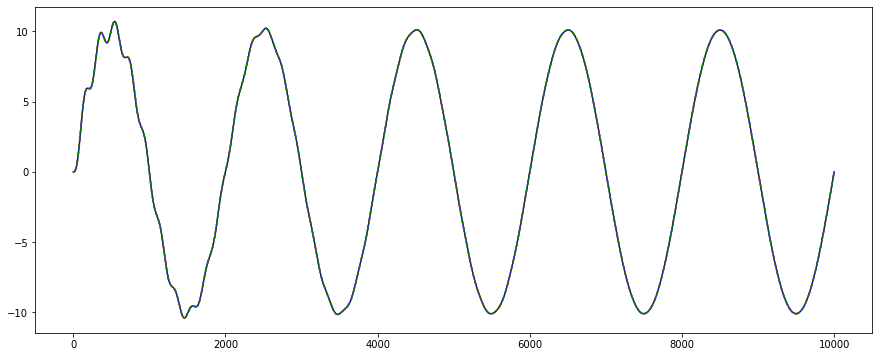

In [18]:
plt.figure(figsize=(15,6));
plt.plot(th_ISO,'b-'); 
plt.plot(th_ri,'r--'); 
#plt.plot(th_conv,'g--');
# plt.plot(th_pl,'r--');
plt.plot(th_nm,'g--');